Graph Structure:


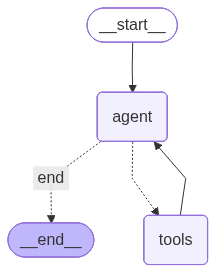

In [3]:
import os
from typing import Literal
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("OPENAI_API_KEY")
BASE_URL = os.getenv("BASE_URL")

# ========== 定义工具函数 ==========
@tool
def get_weather(location: str):
    """Get the current weather for a specific location.
    
    Args:
        location: The city name or location to get weather for
    """
    location_lower = location.lower()
    if "san francisco" in location_lower or "sf" in location_lower:
        return "It's 16 degrees and foggy in San Francisco."
    elif "new york" in location_lower or "ny" in location_lower:
        return "It's 25 degrees and sunny in New York."
    elif "tokyo" in location_lower:
        return "It's 20 degrees and cloudy in Tokyo."
    else:
        return f"It's 22 degrees and partly cloudy in {location}."

@tool
def get_coolest_cities():
    """Get a list of the coolest cities to visit.
    Use this when someone asks for travel recommendations or coolest cities.
    """
    cities = [
        "San Francisco - Known for tech, Golden Gate Bridge, and foggy weather",
        "Tokyo - Amazing food, culture, and technology",
        "Barcelona - Beautiful architecture and beaches",
        "New York - The city that never sleeps",
        "Paris - City of lights and romance"
    ]
    return "\n".join(cities)

# 工具函数列表
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

model_with_tools = ChatOpenAI(
    model="Qwen/Qwen2.5-7B-Instruct",
    api_key=API_KEY,
    base_url=BASE_URL,
    temperature=0
).bind_tools(tools)

# ========== 构建LangGraph ==========
workflow = StateGraph(MessagesState)

# 定义系统提示
system_message = SystemMessage(
    content="""You are a helpful assistant with access to tools.
When users ask about weather, use the get_weather tool.
When users ask about cool cities or travel recommendations, use the get_coolest_cities tool.
Always use the appropriate tool to provide accurate information."""
)

# 定义agent节点
def call_model(state: MessagesState):
    """调用模型，模型会决定是否使用工具"""
    messages = state["messages"]
    
    # 如果没有系统消息，添加一个
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = [system_message] + messages
    
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# 定义条件路由函数
def should_continue(state: MessagesState) -> Literal["tools", "end"]:
    """决定是否调用工具或结束
    
    如果最后一条消息包含tool_calls，则路由到tools节点
    否则，结束执行
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # 检查最后一条消息是否包含工具调用
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print(f"🔧 Tool calls detected: {len(last_message.tool_calls)} tool(s) to execute")
        return "tools"
    else:
        print("✅ No tool calls, ending execution")
        return "end"

# 添加节点
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 设置入口点
workflow.add_edge(START, "agent")

# 添加条件边：从agent节点根据条件路由
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # 如果需要调用工具，路由到tools节点
        "end": END         # 如果不需要调用工具，结束
    }
)

# 工具执行后返回agent节点，让模型生成最终答案
workflow.add_edge("tools", "agent")

# 编译图
app = workflow.compile()

# 显示图结构
print("Graph Structure:")
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:
import json
from typing import Literal

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field

class HaikuRequest(BaseModel):
    topic: list[str] = Field(
        max_length=3,
        min_length=3,
    )

@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatOpenAI(model="Qwen/Qwen2-1.5B-Instruct", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku

def call_tool(state: MessagesState):
    # 创建工具名称到工具函数的映射字典
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]  # 获取最后一条消息
    output_messages = []
    # 遍历最后一条消息中的所有工具调用
    for tool_call in last_message.tool_calls:
        try:
            # 根据工具名称找到对应的工具函数并调用，传入参数
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            # 将工具调用结果封装为ToolMessage添加到输出消息列表
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # 如果工具调用失败，捕获异常并返回错误信息
            # 将错误信息封装为ToolMessage，并在additional_kwargs中标记错误
            output_messages.append(
                ToolMessage(
                    content=str(e), 
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": e},  # 在额外参数中存储错误对象，用于后续错误处理
                )
            )
    return {"messages": output_messages}

# 初始化基础模型（较弱的模型）
model = ChatOpenAI(model="Qwen/Qwen2.5-7B-Instruct", temperature=0, api_key=API_KEY, base_url=BASE_URL)
model_with_tools = model.bind_tools([master_haiku_generator])

# 初始化更强大的模型（用于降级策略）
better_model = ChatOpenAI(model="Qwen/Qwen2.5-32B-Instruct", temperature=0, api_key=API_KEY, base_url=BASE_URL)
better_model_with_tools = better_model.bind_tools([master_haiku_generator])

def should_continue(state: MessagesState):
    # 决定是否继续工具调用循环或结束流程
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # 如果最后一条消息包含工具调用请求
        return "tools"  # 继续执行工具调用
    return END  # 否则结束流程

def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    # 决定是否需要降级到更强大的模型
    messages = state["messages"]
    # 查找是否有失败的工具调用消息（通过 additional_kwargs 中的 error 标记识别）
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:  # 如果存在失败的工具调用
        return "remove_failed_tool_call_attempt"  # 路由到移除失败尝试的节点
    return "agent"  # 否则继续使用当前模型

def call_model(state: MessagesState):
    # 使用基础模型处理消息
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def remove_failed_tool_call_attempt(state: MessagesState):
    # 移除失败的工具调用尝试，清理消息历史
    messages = state["messages"]
    # 从后向前查找最近的AI消息索引
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    # 获取需要移除的消息（从最近的AI消息开始的所有消息）
    messages_to_remove = messages[last_ai_message_index:]
    # 返回移除指令，通过RemoveMessage标记需要移除的消息
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}

# 降级策略：使用更强大的模型重试
def call_fallback_model(state: MessagesState):
    # 使用更强大的模型处理消息
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}

# 创建状态图
workflow = StateGraph(MessagesState)

# 添加节点
workflow.add_node("agent", call_model)  # 基础模型节点
workflow.add_node("tools", call_tool)  # 工具调用节点
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)  # 清理失败尝试节点
workflow.add_node("fallback_agent", call_fallback_model)  # 降级模型节点

# 添加边和条件边
workflow.add_edge(START, "agent")  # 流程从agent节点开始
workflow.add_conditional_edges("agent", should_continue, ["tools", END])  # 根据should_continue函数决定是继续工具调用还是结束
# 根据工具调用结果决定是继续使用当前模型还是清理失败尝试
workflow.add_conditional_edges("tools", should_fallback, path_map = {"agent": "agent", "remove_failed_tool_call_attempt": "remove_failed_tool_call_attempt"}) 
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")  # 清理失败尝试后使用降级模型
workflow.add_edge("fallback_agent", "tools")  # 降级模型生成的工具调用请求继续由tools节点处理

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

🔧 Tool calls detected: 1 tool(s) to execute
✅ No tool calls, ending execution
It's currently 16 degrees and foggy in San Francisco.
